In [1]:
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
from lib_main_transient import case_config

from femvf import load, statefile as sf
from femvf.models import solid as smd, fluid as fmd
from femvf.statefunctional.solid import glottal_width_sharp

import h5utils

In [2]:
# global configuration
ZETA = 1e-4
R_SEP = 1.0
PSUBS = np.arange(200, 1000, 100) * 10
ECOV = 5e3 * 10
EBODY = 15e3 * 10

OUT_DIR = f'out/zeta{ZETA:.2e}_rsep{R_SEP:.1f}'

mesh_name = 'BC-dcov5.00e-02-cl1.00'
mesh_path = f'mesh/{mesh_name}.xml'
model = load.load_fsi_model(mesh_path, None, SolidType=smd.KelvinVoigt, FluidType=fmd.Bernoulli, coupling='explicit')

In [3]:
def glottal_width(model, f):
    props = f.get_properties()
    y = [glottal_width_sharp(model, f.get_state(n), f.get_control(n), props) for n in range(f.size)]
        
    return np.array(y)

def time(model, f):
    return np.array(f.get_times())

In [4]:
case_to_data = {}

for psub in tqdm(PSUBS):
    case = case_config(mesh_name, psub, ECOV, EBODY)
    file_path = f'{OUT_DIR}/{case}.h5'
    
    with sf.StateFile(model, file_path, mode='r') as f:
        case_to_data[f'{case}/glottal_width'] = glottal_width(model, f)
        case_to_data[f'{case}/time'] = time(model, f)

  0%|          | 0/8 [00:00<?, ?it/s]

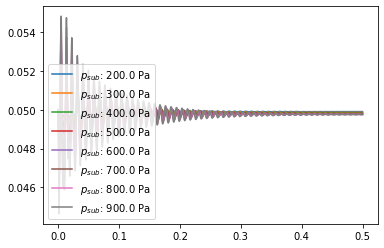

In [6]:
fig, ax = plt.subplots(1, 1)

for psub in PSUBS:
    case = case_config(mesh_name, psub, ECOV, EBODY)
    t = case_to_data[f'{case}/time']
    gw = case_to_data[f'{case}/glottal_width']
    ax.plot(t, gw, label=f"$p_{{sub}}$: {psub/10:.1f} Pa")
    
ax.legend()
# ax.set_xlim(0.49, 0.5)
# ax.set_xlim(

fig.savefig("TransientSimulation.png")